```yaml
    Course:   DS 5001,
    Author:   Raymundo Mora,
    Email:    rm3xw@virginia.edu
    Date:     Spring 2023
```

# Topic Modeling


## 0.0 Import Relevant Libraries

In [1]:
# the two must have libraries in any data science project 
import numpy as np
import pandas as pd

from gensim.models import word2vec
from sklearn.manifold import TSNE
import plotly_express as px


import sqlite3
import pandas as pd
import re


import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display, HTML


import pandas as pd
import numpy as np
import nltk
from numpy.linalg import norm
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist

## 0.1 Import data and Define Global Variables

In [2]:
# relative path to where data will be stored. 
data_dir = "datasets/"
# relative path to our visualization directory
vis_dir = "visualizations/"

#lexicons directory
lex_dir = "datasets/lexicons/"

OHCO = ['track.id','section_num','line_num','token_num'] # define our object heiarchy 


LINE = OHCO[:3]
SECTION = OHCO[:2]
SONG = OHCO[:1]
BAG = SONG

# 1.1 Import our library and modify it to the requirements of this notebook

In [3]:
LIB = pd.read_csv(data_dir+"LIB_english.csv")
LIB = LIB[LIB['artist'] == "Taylor Swift"] # filter to only Taylor Swift

# add a lbel for our dendograms below
LIB['label'] = LIB.artist.str.split(', ').str[0] + ': ' +  LIB.song.str[:20] + ' (' + LIB.index.astype('str') + ')'
LIB['label'] = LIB.label.str.title()

## 1.3 Import our Corpus and modify it for the requirements of this notebook

In [4]:
CORPUS = pd.read_csv(data_dir+"F2_TOKENS_english.csv") 
tswizzle_ids = list(LIB[LIB['artist'] == 'Taylor Swift']['track.id']) # get only the works written by Jane Austen
tswizzle_ids
CORPUS= CORPUS[CORPUS['track.id'].isin(tswizzle_ids)]
CORPUS

,track.id,section_num,line_num,token_num,pos_tuple,pos,token_str,term_str
21803,0Jlcvv8IykzHaSmj49uNW8,1,1,0,"('Im', 'NNP')",NNP,Im,im
21804,0Jlcvv8IykzHaSmj49uNW8,1,1,1,"('doing', 'VBG')",VBG,doing,doing
21805,0Jlcvv8IykzHaSmj49uNW8,1,1,2,"('good', 'JJ')",JJ,good,good
21806,0Jlcvv8IykzHaSmj49uNW8,1,1,3,"('Im', 'NNP')",NNP,Im,im
21807,0Jlcvv8IykzHaSmj49uNW8,1,1,4,"('on', 'IN')",IN,on,on
...,...,...,...,...,...,...,...,...
2300235,7qEUFOVcxRI19tbT68JcYK,1,28,1,"('Taylor', 'NNP')",NNP,Taylor,taylor
2300236,7qEUFOVcxRI19tbT68JcYK,1,28,2,"('Swift', 'NNP')",NNP,Swift,swift
2300237,7qEUFOVcxRI19tbT68JcYK,1,28,3,"('Ready', 'NNP')",NNP,Ready,ready
2300238,7qEUFOVcxRI19tbT68JcYK,1,28,4,"('For', 'IN')",IN,For,for


## 2.0 define the functions we used in our previous HW to help us with the tables for this notebook

In [5]:
def makeBOW(CORPUS,bag_lvl) -> pd.DataFrame:
    """
    Takes a DataFrame that has been tokenized and has a vocabulary
    column named 'term_str'. Returns a dataframe of the word count 
    for each word in 'bag_lvl'. 

    Args:
        CORPUS (pd.DataFrame): DataFrame with a 'term_str' column
            and columns for different parsed levels of the corpus. 
        bag (int): Level of the desired BOW. Based on the 
            index of CORPUS. 

    Returns:
        pd.DataFrame: A DataFrame with a count of 
        how many times each term appeared in the specified 
        level. 
    """
    bag = CORPUS.columns[:bag_lvl].tolist()
    bag.append('term_str')
    BOW = CORPUS.groupby(bag).term_str.count().to_frame('n')
    
    return BOW

In [6]:
def makeTFIDF(BOW,tf_method='sum'):
    
    
    
    # Create Document-Term Count Matrix from BOW
    DTCM = BOW.n.unstack().fillna(0).astype('int')
    
    N = DTCM.shape[0] # Number of documents/bags in the BOW
    
    # Compute TF
    print('TF method:', tf_method)
    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()
    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'log':
        TF = np.log2(1 + DTCM.T)
    elif tf_method == 'raw':
        TF = DTCM.T
    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
    TF = TF.T
    
    # Compute DF
    DF = DTCM.astype('bool').sum()
    
    # Compute IDF
    IDF = np.log2(N / DF)
    
    TFIDF = TF * IDF
    
    # Added a calculation for the DFIDF
    DFIDF = DF*IDF
    
    return TF,DF, IDF, TFIDF,DFIDF

## 3.0 Apply the functions above to the Austen works 

In [7]:
# Generate a BOW by chapters 
BOW = makeBOW(CORPUS,1)

In [8]:
BOW

n
track.id               term_str     
0Jlcvv8IykzHaSmj49uNW8 adventures  1
                       all         2
                       alone       3
                       alright     1
                       and         9
...                               ..
7qEUFOVcxRI19tbT68JcYK with        1
                       woods       1
                       york        1
                       you         6
                       zayn        1

[9220 rows x 1 columns]

In [9]:
# Calculate the below using `max` as our count method
TF, DF, IDF, TFIDF, DFIDF = makeTFIDF(BOW,'max')

TF method: max


## 4.0 Generate a VOCAB table with a `max_pos` column

In [10]:
def gather(ohco_level):
    global CORPUS
    level_name = OHCO[ohco_level-1].split('_')[0]
    df = CORPUS.groupby(OHCO[:ohco_level])\
        .term_str.apply(lambda x: x.str.cat(sep=' '))\
        .to_frame(f"{level_name}_str")
    return df


In [11]:
LINES = gather(3)
LINES.head()

line_str
track.id               section_num line_num                                                   
0Jlcvv8IykzHaSmj49uNW8 1           1                         im doing good im on some new shit
                                   2                             been saying yes instead of no
                                   3         i thought i saw you at the bus stop i didnt th...
                                   4                       i hit the ground running each night
                                   5                                   i hit the sunday matine

In [12]:
keep_whitespace = True
if keep_whitespace:
    TOKENS = LINES.line_str\
            .apply(lambda x: pd.Series(nltk.pos_tag(nltk.word_tokenize(x))))\
            .stack()\
            .to_frame('pos_tuple')
else:
    TOKENS = LINES.line_str\
            .apply(lambda x: pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x))))\
            .stack()\
            .to_frame('pos_tuple')

In [13]:
TOKENS['pos'] = TOKENS.pos_tuple.apply(lambda x: x[1])
TOKENS['token_str'] = TOKENS.pos_tuple.apply(lambda x: x[0])
TOKENS['term_str'] = TOKENS.token_str.str.lower()
TOKENS

pos_tuple  pos token_str  \
track.id               section_num line_num                                  
0Jlcvv8IykzHaSmj49uNW8 1           1        0      (im, NN)   NN        im   
                                            1  (doing, VBG)  VBG     doing   
                                            2    (good, JJ)   JJ      good   
                                            3      (im, NN)   NN        im   
                                            4      (on, IN)   IN        on   
...                                                     ...  ...       ...   
7qEUFOVcxRI19tbT68JcYK 1           28       1  (taylor, NN)   NN    taylor   
                                            2   (swift, NN)   NN     swift   
                                            3   (ready, NN)   NN     ready   
                                            4     (for, IN)   IN       for   
                                            5     (it, PRP)  PRP        it   

                                              term_str  
track.id               section_num line_num             
0Jlcvv8IykzHaSmj49uNW8 1           1        0       im  
                                            1    doing  
                                            2     good  
                                            3       im  
                                            4       on  
...                                                ...  
7qEUFOVcxRI19tbT68JcYK 1           28       1   taylor  
                                            2    swift  
                                            3    ready  
                                            4      for  
                                            5       it  

[24324 rows x 4 columns]

In [14]:
VOCAB = TOKENS.term_str.value_counts().to_frame('n')
VOCAB.index.name = 'term_str'
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['max_pos'] = TOKENS[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)
VOCAB

,n,p,i,n_chars,max_pos
term_str,,,,,
you,1005,0.041317,4.597113,3,PRP
i,990,0.040701,4.618808,1,NN
the,801,0.032930,4.924434,3,DT
and,643,0.026435,5.241418,3,CC
to,390,0.016034,5.962763,2,TO
...,...,...,...,...,...
cranberries,1,0.000041,14.570093,11,NNS
transcend,1,0.000041,14.570093,9,NN
wayne,1,0.000041,14.570093,5,NN


## 4.1  Reduce the features in TFIDF

In [15]:
relevant_pos = ['NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS']
smallVOCAB = VOCAB[VOCAB['max_pos'].isin(relevant_pos)]
relevant_terms = list(smallVOCAB.index)
DFIDF_df = DFIDF.loc[relevant_terms].sort_values(ascending=False).to_frame("DFIDF")
TFIDF_cols = DFIDF_df.index[:1000]
smallTFIDF = TFIDF[TFIDF_cols]
smallTFIDF

term_str,here,ever,are,yeah,think,alone,have,everything,come,been,...,naked,sans,blame,allies,hunt,johnston,friyay,north,process,auxiliary
track.id,,,,,,,,,,,,,,,,,,,,,
0Jlcvv8IykzHaSmj49uNW8,0.000000,0.000000,0.083942,0.000000,0.251827,0.251827,0.305213,0.076303,0.000000,0.872885,...,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
0NRHj8hDwwmSPaA41o379r,0.360143,0.000000,0.075548,0.000000,0.000000,0.075548,0.000000,0.000000,0.000000,0.327332,...,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
0cqRj7pUJDkTCEsJkx8snD,0.000000,0.000000,0.000000,0.038743,0.019371,0.000000,0.000000,0.000000,0.016786,0.033573,...,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
0dBW6ZsW8skfvoRfgeerBF,0.000000,0.332440,0.232456,0.000000,0.000000,0.058114,0.000000,0.052825,0.000000,0.251794,...,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
0k0vFacOHNuArLWMiH60p7,0.041159,0.000000,0.043170,0.000000,0.043170,0.000000,0.078483,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
0tQ9vBYpldCuikPsbgOVKA,0.092940,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.309328,0.000000,...,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
0z9UVN8VBHJ9HdfYsOuuNf,0.019600,0.000000,0.020557,0.000000,0.000000,0.000000,0.018687,0.028030,0.017814,0.000000,...,0.03968,0.03968,0.000000,0.03968,0.03968,0.03968,0.03968,0.03968,0.03968,0.03968
10eBRyImhfqVvkiVEGf0N0,0.000000,0.000000,0.055962,0.000000,0.000000,0.111923,0.254344,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
15DeqWWQB4dcEWzJg15VrN,0.000000,0.000000,0.000000,0.137360,0.000000,0.000000,0.249720,0.062430,0.059515,0.059515,...,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


## 5.0 Collapse the smaller TFIDF matrix and get the mean of each term by book

In [16]:
smallTFIDF = smallTFIDF.groupby('track.id').mean()
smallTFIDF

term_str,here,ever,are,yeah,think,alone,have,everything,come,been,...,naked,sans,blame,allies,hunt,johnston,friyay,north,process,auxiliary
track.id,,,,,,,,,,,,,,,,,,,,,
0Jlcvv8IykzHaSmj49uNW8,0.000000,0.000000,0.083942,0.000000,0.251827,0.251827,0.305213,0.076303,0.000000,0.872885,...,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
0NRHj8hDwwmSPaA41o379r,0.360143,0.000000,0.075548,0.000000,0.000000,0.075548,0.000000,0.000000,0.000000,0.327332,...,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
0cqRj7pUJDkTCEsJkx8snD,0.000000,0.000000,0.000000,0.038743,0.019371,0.000000,0.000000,0.000000,0.016786,0.033573,...,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
0dBW6ZsW8skfvoRfgeerBF,0.000000,0.332440,0.232456,0.000000,0.000000,0.058114,0.000000,0.052825,0.000000,0.251794,...,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
0k0vFacOHNuArLWMiH60p7,0.041159,0.000000,0.043170,0.000000,0.043170,0.000000,0.078483,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
0tQ9vBYpldCuikPsbgOVKA,0.092940,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.309328,0.000000,...,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
0z9UVN8VBHJ9HdfYsOuuNf,0.019600,0.000000,0.020557,0.000000,0.000000,0.000000,0.018687,0.028030,0.017814,0.000000,...,0.03968,0.03968,0.000000,0.03968,0.03968,0.03968,0.03968,0.03968,0.03968,0.03968
10eBRyImhfqVvkiVEGf0N0,0.000000,0.000000,0.055962,0.000000,0.000000,0.111923,0.254344,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
15DeqWWQB4dcEWzJg15VrN,0.000000,0.000000,0.000000,0.137360,0.000000,0.000000,0.249720,0.062430,0.059515,0.059515,...,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


## 6.0 Compute the distance measures between all pairs of books 

In [17]:
L0 = smallTFIDF.astype('bool').astype('int') # Binary (Pseudo L)
L1 = smallTFIDF.apply(lambda x: x / x.sum(), 1) # Probabilistic
L2 = smallTFIDF.apply(lambda x: x / norm(x), 1) # Pythagorean / Euclidean

In [18]:
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([LIB.index.tolist(), LIB.index.tolist()])).reset_index()
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
PAIRS.index.names = ['doc_a', 'doc_b']

In [19]:
PAIRS.shape

(1596, 0)

In [20]:
PAIRS['euclidean'] = pdist(smallTFIDF, 'euclidean')
PAIRS['cityblock'] = pdist(smallTFIDF, 'cityblock')
PAIRS['cosine'] = pdist(smallTFIDF, 'cosine')
PAIRS['jaccard'] = pdist(L0, 'jaccard')
PAIRS['dice'] = pdist(L0, 'dice')
PAIRS['js'] = pdist(L1, 'jensenshannon')  
PAIRS.head()

euclidean  cityblock    cosine   jaccard      dice        js
doc_a doc_b                                                              
1     6       3.392351  31.731912  0.776475  0.869565  0.769231  0.750866
      7       4.965853  25.587664  0.982755  0.868421  0.767442  0.789317
      8       3.649055  31.483638  0.926427  0.889655  0.801242  0.776938
      9       3.128808  23.750738  0.957442  0.858333  0.751825  0.778430
      10      3.742951  27.851444  0.949402  0.894231  0.808696  0.790670

## 7.0 Create hierarchical agglomerative cluster diagrams for the measures of each distance

In [21]:
def hca(sims, linkage_method='complete', color_thresh=.3, figsize=(10, 20)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = LIB.label.values
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)
    return fig

## <center>HCA for Cosine Distance Measure</center>

<Figure size 640x480 with 0 Axes>

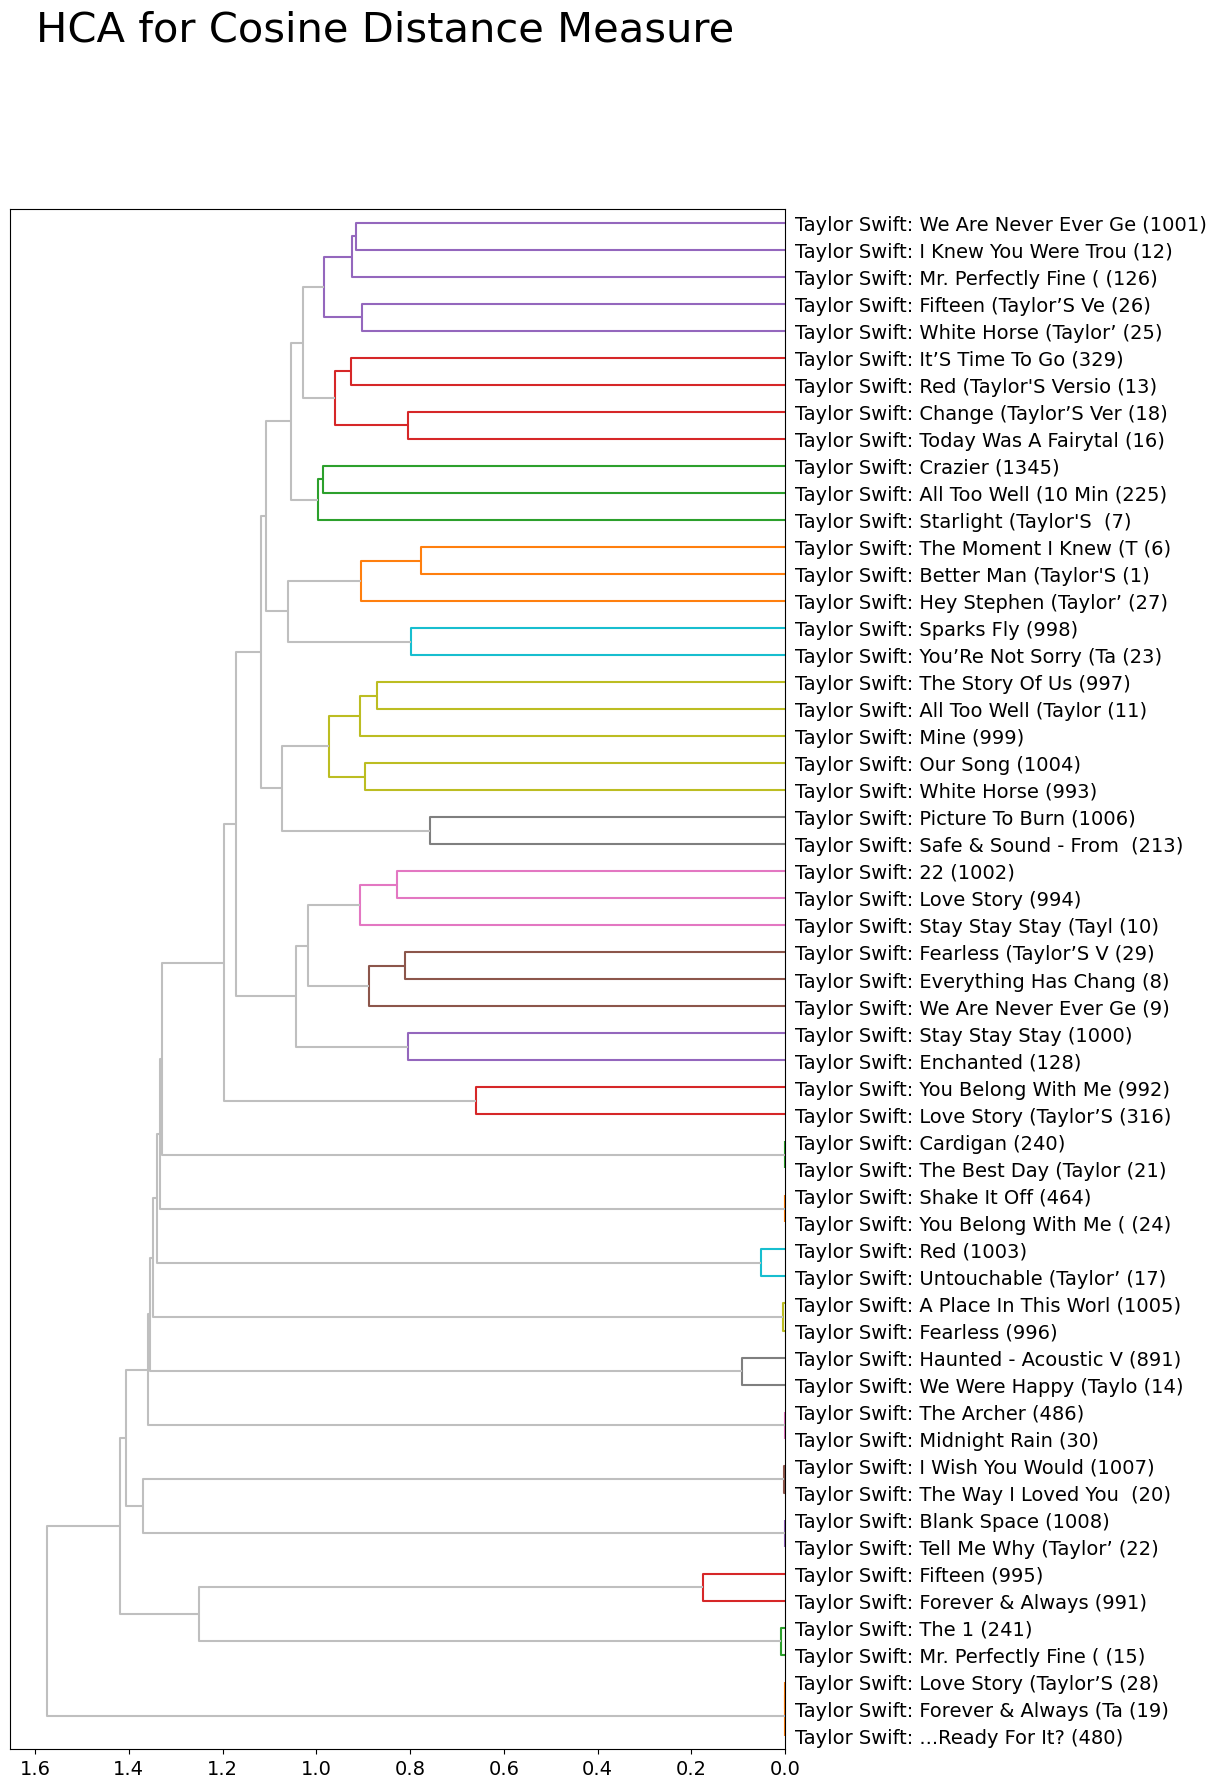

In [22]:
fig = hca(PAIRS.cosine, linkage_method='ward', color_thresh=1)
plt.suptitle('HCA for Cosine Distance Measure',fontsize=30)
plt.savefig(vis_dir+"8.1.png",bbox_inches='tight',pad_inches=0.1)

In [23]:
PAIRS['cosine'].sort_values(ascending=True)

doc_a  doc_b
19     480      0.000000
21     240      0.000000
19     28       0.000000
22     1008     0.000000
28     480      0.000000
                  ...   
128    997      0.999121
1001   1345     0.999215
23     1345     0.999258
1007   1345     0.999735
20     1345     0.999735
Name: cosine, Length: 1596, dtype: float64

In [24]:
plt.savefig(vis_dir+"8.1.png",pad_inches=0.1)

<Figure size 640x480 with 0 Axes>